## Offsets
offsets were decided based on `1920` by `1080` full screen firefox window using spookfish mapviewer, with a `z index` of 20. `z index` is a parameter in the url determining the image view height, so naturally this will affect what offsets we use.

In [14]:
long_offset = 0.00247
lat_offset = 0.00093

## First create spatial index

In [15]:
import fiona
from rtree import index
import pandas
from shapely.geometry import asShape, Point

In [16]:
tree_index = index.Index()

## Get Metro LGAs only

In [17]:
mapping = pandas.read_csv('./lga-mappings-2.csv')

In [18]:
metro_filter = mapping[mapping['Section of State'] == 'Metropolitan Melbourne']['LGA CODE']

In [19]:
list_of_metro_lgas = list(map(str,list(metro_filter)))

In [20]:
print(list_of_metro_lgas)

['20660', '20910', '21110', '21180', '21450', '21610', '21890', '22170', '22310', '22670', '23110', '23270', '23430', '23670', '24210', '24330', '24410', '24600', '24650', '24970', '25060', '25250', '25340', '25710', '25900', '26350', '26980', '27070', '27260', '27350', '27450']


## Import Shape file

In [21]:
australia = fiona.open('../1270055003_lga_2018_aust_shape/LGA_2018_AUST.shp')
metro_victoria = [asShape(lga['geometry']).simplify(tolerance=.000005) for lga in australia \
            if lga['geometry'] is not None \
            and lga['properties']['STE_NAME16'] == 'Victoria' \
            and lga['properties']['LGA_CODE18'] in list_of_metro_lgas]
metro_properties = [lga['properties'] for lga in australia \
            if lga['geometry'] is not None \
            and lga['properties']['STE_NAME16'] == 'Victoria' \
            and lga['properties']['LGA_CODE18'] in list_of_metro_lgas]

## Calculate Metro Victoria Bounds

In [22]:
for index, shape in enumerate(metro_victoria):
    tree_index.insert(index, shape.bounds)

In [23]:
metro_victoria_box = tree_index.bounds

In [24]:
metro_victoria_box

[144.444061002, -38.50298801599996, 146.19250210600012, -37.40175035499993]

In [25]:
metro_victoria_box_final = [round(value, 5) for value in metro_victoria_box]

In [26]:
metro_victoria_box_final

[144.44406, -38.50299, 146.1925, -37.40175]

## Find the Longitudes within Metro Victorias bounding box, given our offset value

In [27]:
possible_longs = []

mutable_longitude = metro_victoria_box[0]

while mutable_longitude < metro_victoria_box[2]:
    mutable_longitude += long_offset
    possible_longs.append(mutable_longitude)

In [28]:
len(possible_longs)

708

## Next, find the latitudes within Victorias bounding box, given our offset value

In [29]:
possible_lats = []

mutable_latitude = metro_victoria_box[1]

while mutable_latitude < metro_victoria_box[3]:
    mutable_latitude += lat_offset
    possible_lats.append(mutable_latitude)

In [30]:
len(possible_lats)

1185

## Next compile into list of `x,y` coordinates

In [31]:
coordinates = []

for x in possible_longs:
    for y in possible_lats:
        coordinates.append((x,y))

## Show length of coordinate list, as well as previewing the tailing 5 sets of coodinates
There appears to be 167,958 possible points within the metro victoria region, including overlapping points in the ocean or rural regions.

In [32]:
len(coordinates)

838980

In [33]:
coordinates[:5]

[(144.446531002, -38.502058015999964),
 (144.446531002, -38.50112801599997),
 (144.446531002, -38.50019801599997),
 (144.446531002, -38.499268015999974),
 (144.446531002, -38.49833801599998)]

In [34]:
coordinates[-5:]

[(146.19282100199166, -37.40465801600378),
 (146.19282100199166, -37.40372801600378),
 (146.19282100199166, -37.402798016003786),
 (146.19282100199166, -37.40186801600379),
 (146.19282100199166, -37.40093801600379)]

## For now, we just want to do one local government area
I'll choose bayside which is indexed at 1

In [35]:
metro_properties[1]

OrderedDict([('LGA_CODE18', '20910'),
             ('LGA_NAME18', 'Bayside (C)'),
             ('STE_CODE16', '2'),
             ('STE_NAME16', 'Victoria'),
             ('AREASQKM18', 37.2111)])

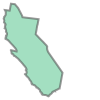

In [36]:
metro_victoria[1]

In [37]:
metro_victoria[1].bounds

(144.9833816800001, -37.99644678599998, 145.0552672990001, -37.883273516999964)

In [38]:
bayside_limits = metro_victoria[1].bounds

def is_it_in_bayside(coord):
     if coord[0] >= bayside_limits[0] and \
        coord[0] <= bayside_limits[2] and \
        coord[1] >= bayside_limits[1] and \
        coord[1] <= bayside_limits[3]:
        return coord

In [39]:
check_bayside_list = list(map(is_it_in_bayside, coordinates))
within_bayside_bounding_box = [coord for coord in check_bayside_list if coord is not None]
within_bayside_bounding_box_points = [Point(coord) for coord in check_bayside_list if coord is not None]

# These points are within Baysides bounding box, now to knock out points that are not within Baysides Boundary

In [40]:
len(within_bayside_bounding_box)

3538

In [41]:
within_bayside_boundary = [coord for coord in within_bayside_bounding_box \
                           if metro_victoria[1].intersects(Point(coord))]

# How many points are within Bayside's boundary?

In [42]:
len(within_bayside_boundary)

1657

## Export results to csv

In [43]:
import pandas

In [44]:
data_dict = {'longitude':[], 'latitude':[]}

for coord in within_bayside_boundary:
    data_dict['longitude'].append(coord[0])
    data_dict['latitude'].append(coord[1])

In [45]:
data = pandas.DataFrame(data_dict)

In [46]:
data.shape

(1657, 2)

In [47]:
data.head(15)

,longitude,latitude
0,144.984991,-37.913368
1,144.984991,-37.906858
2,144.984991,-37.905928
3,144.984991,-37.904998
4,144.984991,-37.904068
5,144.984991,-37.903138
6,144.984991,-37.902208
7,144.984991,-37.901278
8,144.984991,-37.900348
9,144.984991,-37.899418


In [48]:
data.to_csv('bayside_coordinates.csv', index = True, index_label = 'row_index')